<a href="https://colab.research.google.com/github/vimesh630/Stock-Price-Forecast-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
# Import all required libraries
from google.colab import drive
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

Mount Drive and Install Dependecies

In [2]:
# Mount Google Drive for saving files
drive.mount('/content/drive')

# Install yfinance (not pre-installed in Colab)
!pip install yfinance

Mounted at /content/drive


Download Historical Dataset

In [3]:
# Define stocks to predict
stocks = ["AAPL", "TSLA", "MSFT", "GOOGL", "AMZN", "NVDA"]

# Fetch 5 years of historical closing prices
data = {}
for stock in stocks:
    ticker = yf.Ticker(stock)
    data[stock] = ticker.history(period="5y")["Close"]

# Combine into a DataFrame with original dates
df = pd.DataFrame(data)

# Save raw dataset to Google Drive
df.to_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_raw.csv")
print("Historical dataset downloaded and saved to Drive!")
df.head()

Historical dataset downloaded and saved to Drive!


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA
Date,,,,,,
2020-03-23 00:00:00-04:00,54.449890,28.952667,130.157150,52.455711,95.141502,5.297731
2020-03-24 00:00:00-04:00,59.912598,33.666668,141.987869,56.231663,97.004997,6.206633
2020-03-25 00:00:00-04:00,59.582554,35.950001,140.628662,54.818916,94.292000,6.117960
2020-03-26 00:00:00-04:00,62.717972,35.210667,149.425140,57.869331,97.774498,6.407394
2020-03-27 00:00:00-04:00,60.121307,34.290668,143.289688,55.248859,95.004997,6.295056


Preprocess Dataset

In [4]:
# Load raw dataset (optional if restarting Colab)
df = pd.read_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_raw.csv", index_col="Date", parse_dates=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Fill missing values with forward fill (if any)
df.fillna(method="ffill", inplace=True)

# Add features: previous day's price and 7-day moving average
for stock in stocks:
    df[f"{stock}_Prev"] = df[stock].shift(1)  # Previous day's price
    df[f"{stock}_MA7"] = df[stock].rolling(window=7).mean()  # 7-day MA

# Drop rows with NaN from shifting/rolling
df.dropna(inplace=True)

# Save preprocessed dataset to Google Drive
df.to_csv("/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/multi_stock_data_preprocessed.csv")
print("Dataset preprocessed and saved to Drive!")
df.head()

Missing values:
 AAPL     0
TSLA     0
MSFT     0
GOOGL    0
AMZN     0
NVDA     0
dtype: int64


<ipython-input-4-52645eac65c2>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


Dataset preprocessed and saved to Drive!


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2020-03-31 00:00:00-04:00,61.710854,34.933334,150.956680,57.821060,97.486000,6.565810,61.837048,60.047460,33.475334,33.782763,153.368729,144.259131,57.042778,55.926903,98.197502,96.414500,6.615377,6.215137
2020-04-01 00:00:00-04:00,58.463806,32.104000,145.596451,54.842796,95.385002,6.054443,61.710854,60.620877,34.933334,34.232953,150.956680,146.464746,57.821060,56.267915,97.486000,96.449285,6.565810,6.323239
2020-04-02 00:00:00-04:00,59.439369,30.298000,148.611572,55.585747,95.941498,6.363306,58.463806,60.553273,32.104000,33.751715,145.596451,147.410989,54.842796,56.175641,95.385002,96.297357,6.054443,6.345621
2020-04-03 00:00:00-04:00,58.585144,32.000668,147.242783,54.375034,95.329498,6.075367,59.439369,60.410786,30.298000,33.187525,148.611572,148.355863,55.585747,56.112229,95.941498,96.445571,6.363306,6.339536
2020-04-06 00:00:00-04:00,63.695972,34.416000,158.192917,58.878010,99.879501,6.685369,58.585144,60.550500,32.000668,33.074001,147.242783,149.608403,54.375034,56.256326,95.329498,96.746286,6.075367,6.379247


Update Data with Latest Prices

In [5]:
# Function to update data with the latest prices
def update_stock_data(df, stocks):
    new_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        new_data[stock] = ticker.history(period="1d")["Close"]
        if not new_data[stock].empty:
            latest_date = new_data[stock].index[-1] # Get latest date as Timestamp object
            # latest_date = new_data[stock].index[-1].strftime('%Y-%m-%d') # Removed strftime conversion
            latest_price = new_data[stock].iloc[-1]
            if latest_date not in df.index:
                # Extend with previous row using correct index type
                df.loc[latest_date] = df.iloc[-1].values
            df.loc[latest_date, stock] = latest_price  # Update price
    return df

# Update with latest data
df = update_stock_data(df, stocks)
print("Data updated with latest prices:")
df.tail()

Data updated with latest prices:


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2025-03-17 00:00:00-04:00,214.000000,238.009995,388.700012,164.289993,195.740005,119.529999,213.490005,220.219999,249.979996,241.737141,388.559998,384.745714,165.490005,166.174284,197.949997,196.692856,121.669998,114.417114
2025-03-18 00:00:00-04:00,212.690002,225.309998,383.519989,160.669998,192.820007,115.430000,214.000000,216.451427,238.009995,236.399996,388.700012,383.347142,164.289993,164.318569,195.740005,195.774285,119.529999,114.810023
2025-03-19 00:00:00-04:00,215.240005,235.860001,387.820007,163.889999,195.539993,117.519997,212.690002,214.702857,225.309998,238.358568,383.519989,384.441428,160.669998,164.035712,192.820007,195.917143,115.430000,116.317142
2025-03-20 00:00:00-04:00,214.100006,236.259995,386.839996,162.800003,194.949997,118.529999,215.240005,213.740001,235.860001,239.169996,387.820007,385.354283,163.889999,163.858571,195.539993,195.682857,117.519997,117.714285
2025-03-21 00:00:00-04:00,218.270004,248.710007,391.260010,163.990005,196.210007,117.699997,214.100006,213.924288,236.259995,239.258569,386.839996,386.495714,162.800003,163.412857,194.949997,195.300001,118.529999,117.994284


Prepare Features for Real-Time Training

In [6]:
# Recalculate features after update
for stock in stocks:
    df[f"{stock}_Prev"] = df[stock].shift(1)  # Recalculate previous day's price
    df[f"{stock}_MA7"] = df[stock].rolling(window=7).mean()  # Recalculate 7-day MA

# Drop rows with NaN from shifting/rolling
df.dropna(inplace=True)

# Display prepared data
print("Data with updated features:")
df.tail()

Data with updated features:


,AAPL,TSLA,MSFT,GOOGL,AMZN,NVDA,AAPL_Prev,AAPL_MA7,TSLA_Prev,TSLA_MA7,MSFT_Prev,MSFT_MA7,GOOGL_Prev,GOOGL_MA7,AMZN_Prev,AMZN_MA7,NVDA_Prev,NVDA_MA7
Date,,,,,,,,,,,,,,,,,,
2025-03-17 00:00:00-04:00,214.000000,238.009995,388.700012,164.289993,195.740005,119.529999,213.490005,220.219999,249.979996,241.737141,388.559998,384.745714,165.490005,166.174284,197.949997,196.692856,121.669998,114.417114
2025-03-18 00:00:00-04:00,212.690002,225.309998,383.519989,160.669998,192.820007,115.430000,214.000000,216.451427,238.009995,236.399996,388.700012,383.347142,164.289993,164.318569,195.740005,195.774285,119.529999,114.810023
2025-03-19 00:00:00-04:00,215.240005,235.860001,387.820007,163.889999,195.539993,117.519997,212.690002,214.702857,225.309998,238.358568,383.519989,384.441428,160.669998,164.035712,192.820007,195.917143,115.430000,116.317142
2025-03-20 00:00:00-04:00,214.100006,236.259995,386.839996,162.800003,194.949997,118.529999,215.240005,213.740001,235.860001,239.169996,387.820007,385.354283,163.889999,163.858571,195.539993,195.682857,117.519997,117.714285
2025-03-21 00:00:00-04:00,218.270004,248.710007,391.260010,163.990005,196.210007,117.699997,214.100006,213.924288,236.259995,239.258569,386.839996,386.495714,162.800003,163.412857,194.949997,195.300001,118.529999,117.994284


Train the Model

In [7]:
# Define features (X) and targets (y)
feature_cols = [f"{stock}_Prev" for stock in stocks]
X = df[feature_cols]
y = df[stocks]

# Split data: 80% train, 20% test, and keep the last row for real-time prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_latest = X.iloc[-1:]  # Last row for real-time prediction

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate on test set
predictions = model.predict(X_test)

# Calculate metrics for each stock
mae = mean_absolute_error(y_test, predictions, multioutput="raw_values")
mse = mean_squared_error(y_test, predictions, multioutput="raw_values")
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test), axis=0) * 100  # MAPE as percentage
r2 = r2_score(y_test, predictions, multioutput="raw_values")

# Store metrics in a dictionary for display
metrics = {
    "Stock": stocks,
    "MAE (USD)": mae,
    "MSE (USD^2)": mse,
    "RMSE (USD)": rmse,
    "MAPE (%)": mape,
    "R²": r2
}

# Display metrics
metrics_df = pd.DataFrame(metrics)
print("Model Performance Metrics on Test Set:")
print(metrics_df)

print("Model trained successfully!")

Model Performance Metrics on Test Set:
       Stock  MAE (USD)  MSE (USD^2)  RMSE (USD)  MAPE (%)        R²
AAPL    AAPL   3.218844    15.595596    3.949126  1.461020  0.971797
TSLA    TSLA   8.912120   155.448628   12.467904  3.316776  0.978601
MSFT    MSFT   5.240975    48.432306    6.959332  1.255466  0.832140
GOOGL  GOOGL   2.254354     9.870805    3.141784  1.298169  0.941383
AMZN    AMZN   2.709163    12.692509    3.562655  1.379411  0.965733
NVDA    NVDA   3.225295    18.022097    4.245244  2.719803  0.945690
Model trained successfully!


Make Real-Time Predictions

In [8]:
# Use the last row for real-time prediction
X_latest = X.iloc[-1:]

# Predict on the latest data (real-time forecast)
latest_predictions = model.predict(X_latest)
print("\nReal-time forecast for next day:")
for stock, pred in zip(stocks, latest_predictions[0]):
    print(f"{stock}: ${pred:.2f}")

# Reference metrics for context
print("\nModel Accuracy (from historical test set):")
print(metrics_df)


Real-time forecast for next day:
AAPL: $211.82
TSLA: $232.68
MSFT: $391.06
GOOGL: $162.58
AMZN: $194.11
NVDA: $118.21

Model Accuracy (from historical test set):
       Stock  MAE (USD)  MSE (USD^2)  RMSE (USD)  MAPE (%)        R²
AAPL    AAPL   3.218844    15.595596    3.949126  1.461020  0.971797
TSLA    TSLA   8.912120   155.448628   12.467904  3.316776  0.978601
MSFT    MSFT   5.240975    48.432306    6.959332  1.255466  0.832140
GOOGL  GOOGL   2.254354     9.870805    3.141784  1.298169  0.941383
AMZN    AMZN   2.709163    12.692509    3.562655  1.379411  0.965733
NVDA    NVDA   3.225295    18.022097    4.245244  2.719803  0.945690


Visualise Results

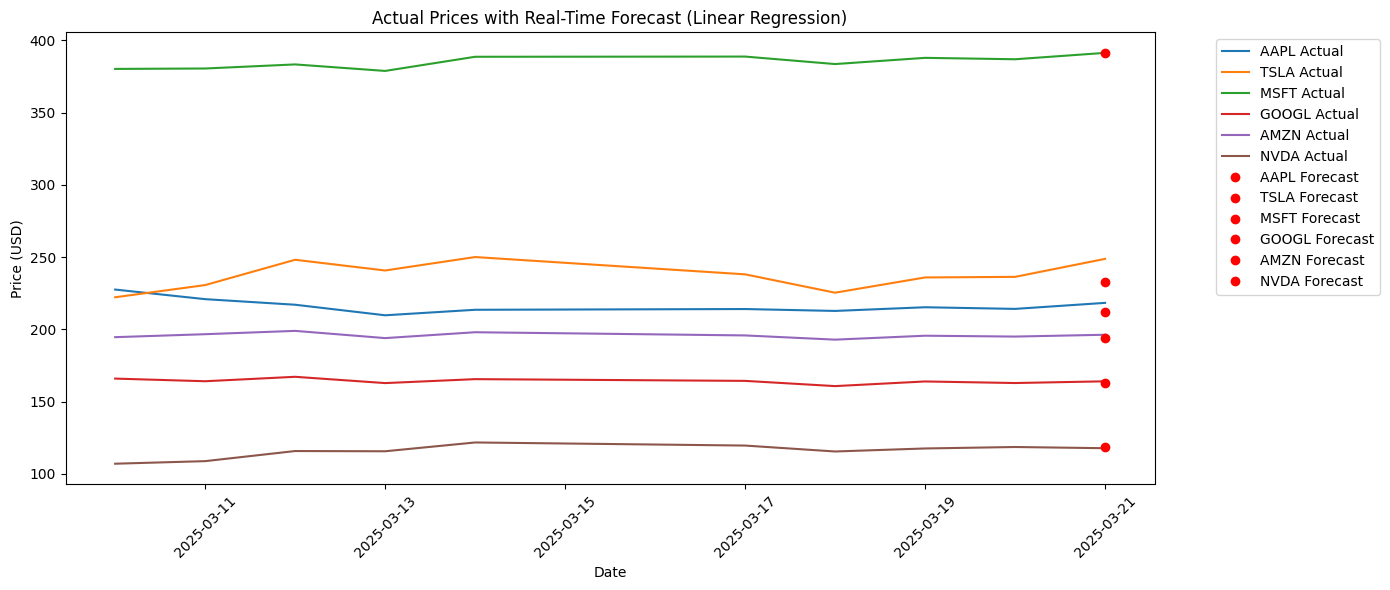

In [9]:
# Visualize actual prices with real-time forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-10:], y.iloc[-10:], label=[f"{stock} Actual" for stock in stocks])  # Last 10 days

# Iterate over stocks and predictions to create individual forecast points
for i, stock in enumerate(stocks):
    plt.plot(df.index[-1], latest_predictions[0][i], 'ro', label=f"{stock} Forecast")

plt.title("Actual Prices with Real-Time Forecast (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside to avoid clutter
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Save the Model

In [10]:
# Save the model to Google Drive for web application
model_save_path = "/content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/stock_model_realtime.pkl"
joblib.dump(model, model_save_path)
print(f"Model saved to {model_save_path} for web application!")

Model saved to /content/drive/MyDrive/Individual_Projects/Stock_Price_Prediction/stock_model_realtime.pkl for web application!
